[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving test_dataset.csv to test_dataset (4).csv
Saving train_dataset.csv to train_dataset (4).csv
Saving validation_dataset.csv to validation_dataset (4).csv
                                                text             intent
0  could YOU set up a meeting with manager AT 5:4...  calendar_schedule
1                      Hey, basically how's it going       general_chat
2          Can you i need information about expense?    knowledge_query
3  Hello please book a meeting with committee at ...  calendar_schedule
4                              Hey, how's it going!!       general_chat
                                              text           intent
0  I need to send an email to maria about meeting.       email_send
1  I need to what is our company's expense policy.  knowledge_query
2          can you how does per4mance review work?  knowledge_query
3          Please look up information about report       web_search
4                 i want tu search for deadline.!!       web_search
  

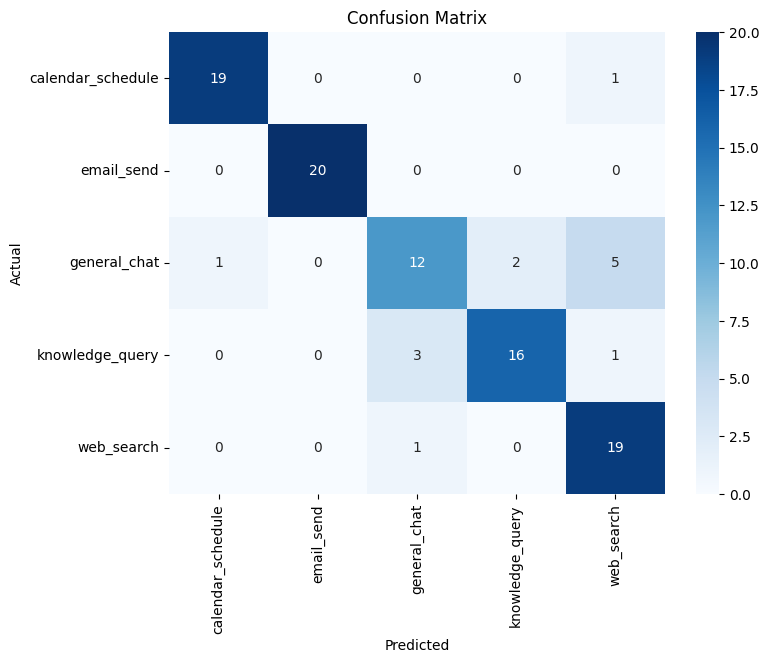


🔎 Sample Misclassified Examples:
                                                 text             intent  \
2                         I need to what's happening.       general_chat   
3                       would u mind what's right up?       general_chat   
13                                 plezse how ARE you       general_chat   
19  Creste a calebdar event wigh client on tomorrow!!  calendar_schedule   
20        What's the basically proceds for promotion?    knowledge_query   
28                Hey, tell me ABIUT company parental    knowledge_query   
31                                         how are U.       general_chat   
32                     Hey tell me about company sick    knowledge_query   
43                                       hpw are you.       general_chat   
49                          How do I report an issue?    knowledge_query   

          predicted  
2   knowledge_query  
3        web_search  
13       web_search  
19       web_search  
20     general_chat

In [3]:
# =========================================
# 0️⃣ Install & Import Required Libraries
# =========================================
!pip install nltk scikit-learn imbalanced-learn matplotlib seaborn wordcloud --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

nltk.download('punkt')
nltk.download('stopwords')

# =========================================
# 1️⃣ Load Datasets
# =========================================
# ✅ Colab file upload
from google.colab import files
import pandas as pd

# Upload files (a dialog will appear)
uploaded = files.upload()

# Once uploaded, read the CSVs
train_df = pd.read_csv(list(uploaded.keys())[0])  # pick the first uploaded file
val_df = pd.read_csv(list(uploaded.keys())[1])    # second uploaded file
test_df = pd.read_csv(list(uploaded.keys())[2])   # third uploaded file

# Quick check
print(train_df.head())
print(val_df.head())
print(test_df.head())


# Inspect the data
print(train_df.head())
print(train_df['text'].value_counts())

# =========================================
# 2️⃣ Data Preprocessing
# =========================================
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                        # Lowercase
    text = re.sub(r'\n',' ', text)                  # Remove newlines
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)     # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
for df in [train_df, val_df, test_df]:
    df['processed_text'] = df['text'].apply(clean_text)

# Handle class imbalance (Optional: SMOTE)
X_train = train_df['processed_text']
y_train = train_df['intent']  # Replace 'intent' with your target column
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

smote = SMOTE(random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train_enc)

# =========================================
# 3️⃣ Feature Engineering & Model Selection
# =========================================
# Using TF-IDF vectorization + Logistic Regression as lightweight approach
X_val_vec = vectorizer.transform(val_df['processed_text'])
y_val_enc = le.transform(val_df['intent'])

# =========================================
# 4️⃣ Model Development & Optimization
# =========================================
# Logistic Regression with hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr = LogisticRegression(max_iter=500)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_
print("✅ Best Model Parameters:", grid.best_params_)

# =========================================
# 5️⃣ Evaluation
# =========================================
X_test_vec = vectorizer.transform(test_df['processed_text'])
y_test_enc = le.transform(test_df['intent'])

y_pred = best_model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# =========================================
# 6️⃣ Error Analysis & Insights
# =========================================
test_df['predicted'] = le.inverse_transform(y_pred)
test_df['correct'] = test_df['intent'] == test_df['predicted']

# Show some misclassified examples
misclassified = test_df[test_df['correct']==False]
print("\n🔎 Sample Misclassified Examples:")
print(misclassified[['text','intent','predicted']].head(10))

# Confidence-based filtering
y_proba = best_model.predict_proba(X_test_vec)
confidence = np.max(y_proba, axis=1)
test_df['confidence'] = confidence

# Filter low-confidence predictions (<0.6)
low_conf = test_df[test_df['confidence'] < 0.6]
print(f"\nNumber of low-confidence predictions: {len(low_conf)}")



🔹 Training Logistic Regression...
Accuracy: 0.8600

Classification Report:
                   precision    recall  f1-score   support

calendar_schedule       0.95      0.95      0.95        20
       email_send       1.00      1.00      1.00        20
     general_chat       0.75      0.60      0.67        20
  knowledge_query       0.89      0.80      0.84        20
       web_search       0.73      0.95      0.83        20

         accuracy                           0.86       100
        macro avg       0.86      0.86      0.86       100
     weighted avg       0.86      0.86      0.86       100



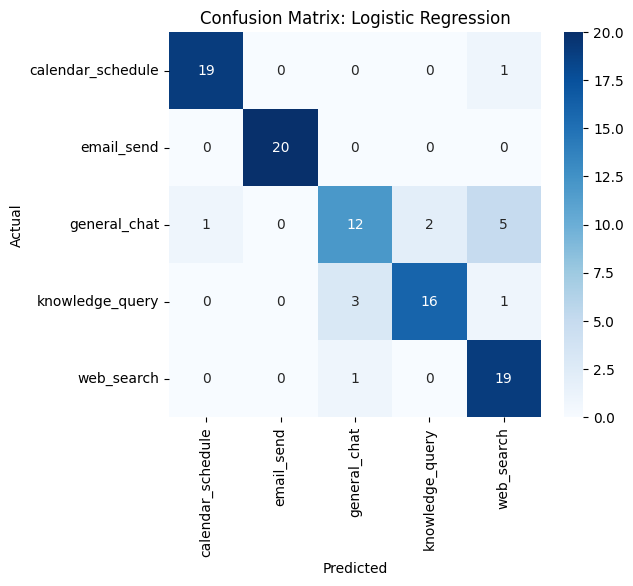


🔹 Training Multinomial Naive Bayes...
Accuracy: 0.8800

Classification Report:
                   precision    recall  f1-score   support

calendar_schedule       0.83      1.00      0.91        20
       email_send       0.87      1.00      0.93        20
     general_chat       0.82      0.70      0.76        20
  knowledge_query       0.94      0.75      0.83        20
       web_search       0.95      0.95      0.95        20

         accuracy                           0.88       100
        macro avg       0.88      0.88      0.88       100
     weighted avg       0.88      0.88      0.88       100



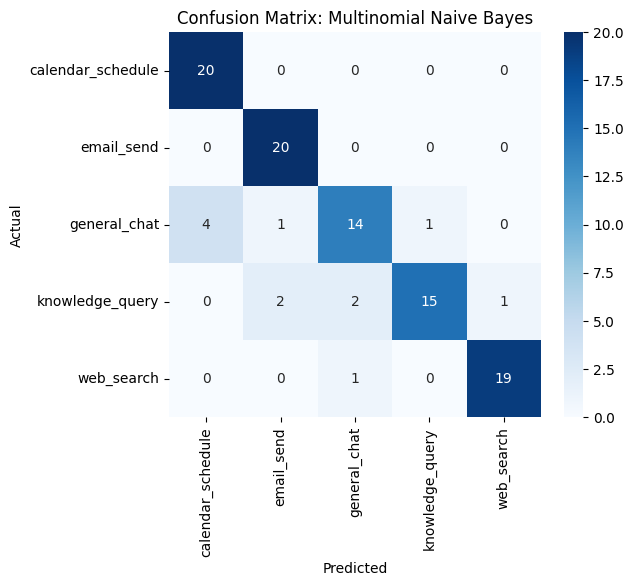


🔹 Training Linear SVM...
Accuracy: 0.8800

Classification Report:
                   precision    recall  f1-score   support

calendar_schedule       1.00      0.90      0.95        20
       email_send       1.00      1.00      1.00        20
     general_chat       0.81      0.65      0.72        20
  knowledge_query       0.89      0.85      0.87        20
       web_search       0.74      1.00      0.85        20

         accuracy                           0.88       100
        macro avg       0.89      0.88      0.88       100
     weighted avg       0.89      0.88      0.88       100



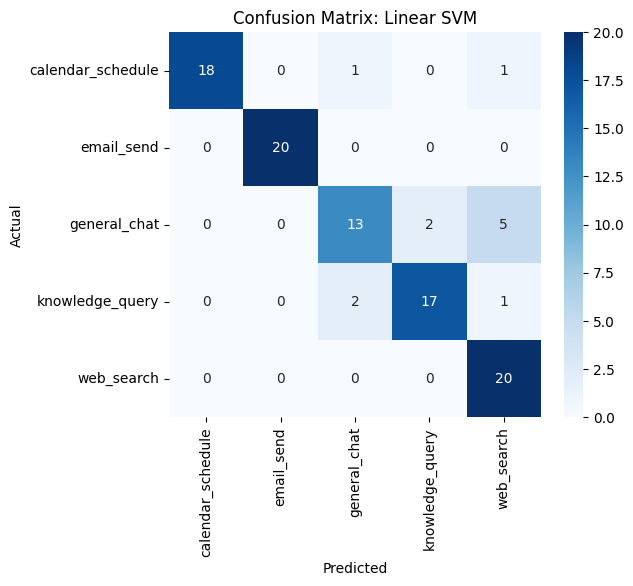

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(C=10, solver='liblinear', max_iter=500),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": SVC(kernel='linear')
}

# Fit models and evaluate
X_train_vec = vectorizer.fit_transform(train_df['processed_text'])
y_train_enc = le.fit_transform(train_df['intent'])
X_test_vec = vectorizer.transform(test_df['processed_text'])
y_test_enc = le.transform(test_df['intent'])

results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_vec, y_train_enc)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

    # Save results
    results[name] = {"model": model, "accuracy": acc, "y_pred": y_pred}

    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [6]:
import joblib

# Save trained model
joblib.dump(best_model, "intent_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Save LabelEncoder
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [7]:
from google.colab import files

files.download("intent_model.pkl")
files.download("tfidf_vectorizer.pkl")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>